In [25]:
import numpy as np
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt
from scipy.special import softmax
import matplotlib.ticker as mticker
import os

image_output_directory = "./images"
os.makedirs(image_output_directory, exist_ok=True)



In [2]:
classes = [
    "background",
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motorcycle",
    "bicycle",
]

In [3]:
method = np.load("CITL-291.npz")
baseline = np.load("CITL-286.npz")

method_images = method["images"]
method_predictions = method["predictions"]
method_ground_truths = method["ground_truths"]
method_predictions = softmax(method_predictions, axis=1)

baseline_images = baseline["images"]
baseline_predictions = baseline["predictions"]
baseline_ground_truths = baseline["ground_truths"]
baseline_predictions = softmax(baseline_predictions, axis=1)

In [4]:
num_images = method_images.shape[0]
num_classes = method_predictions.shape[1]

method_all_fraction_of_positives = {i: [] for i in range(1, num_classes)}
method_all_mean_predicted_value = {i: [] for i in range(1, num_classes)}
method_all_predicted_probabilities = {i: [] for i in range(1, num_classes)}

for positive_class in range(1, 20):

    for img in range(method_images.shape[0]):
        ground_truth = method_ground_truths[img].flatten()

        if positive_class not in ground_truth:
            continue
        
        method_prediction = method_predictions[img]
        probabilities_hwc = np.transpose(method_prediction, (1, 2, 0))
        flat_probabilities = probabilities_hwc.reshape(-1, probabilities_hwc.shape[-1])
        
        y_true_binary = (ground_truth == positive_class).astype(int)
        y_prob_positive = flat_probabilities[:, positive_class]
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true_binary, y_prob_positive, n_bins=20)

        method_all_fraction_of_positives[positive_class].append(fraction_of_positives)
        method_all_mean_predicted_value[positive_class].append(mean_predicted_value)
        method_all_predicted_probabilities[positive_class].extend(y_prob_positive)

for key, val in method_all_predicted_probabilities.items():
    method_all_predicted_probabilities[key] = np.array(method_all_predicted_probabilities[key])

In [5]:
num_images = baseline_images.shape[0]
num_classes = baseline_predictions.shape[1]

baseline_all_fraction_of_positives = {i: [] for i in range(1, num_classes)}
baseline_all_mean_predicted_value = {i: [] for i in range(1, num_classes)}
baseline_all_predicted_probabilities = {i: [] for i in range(1, num_classes)}

for positive_class in range(1, 20):

    for img in range(baseline_images.shape[0]):
        ground_truth = baseline_ground_truths[img].flatten()

        if positive_class not in ground_truth:
            continue
        
        baseline_prediction = baseline_predictions[img]
        probabilities_hwc = np.transpose(baseline_prediction, (1, 2, 0))
        flat_probabilities = probabilities_hwc.reshape(-1, probabilities_hwc.shape[-1])
        
        y_true_binary = (ground_truth == positive_class).astype(int)
        y_prob_positive = flat_probabilities[:, positive_class]
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true_binary, y_prob_positive, n_bins=100)

        baseline_all_fraction_of_positives[positive_class].append(fraction_of_positives)
        baseline_all_mean_predicted_value[positive_class].append(mean_predicted_value)
        baseline_all_predicted_probabilities[positive_class].extend(y_prob_positive)

for key, val in baseline_all_predicted_probabilities.items():
    baseline_all_predicted_probabilities[key] = np.array(baseline_all_predicted_probabilities[key])

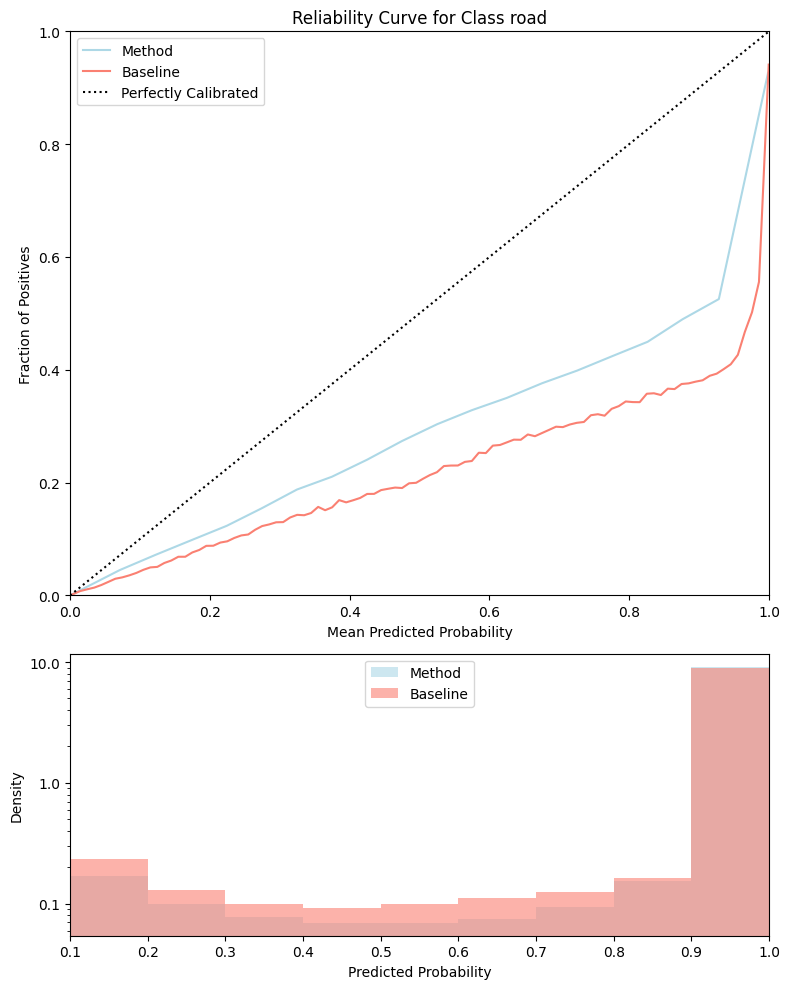

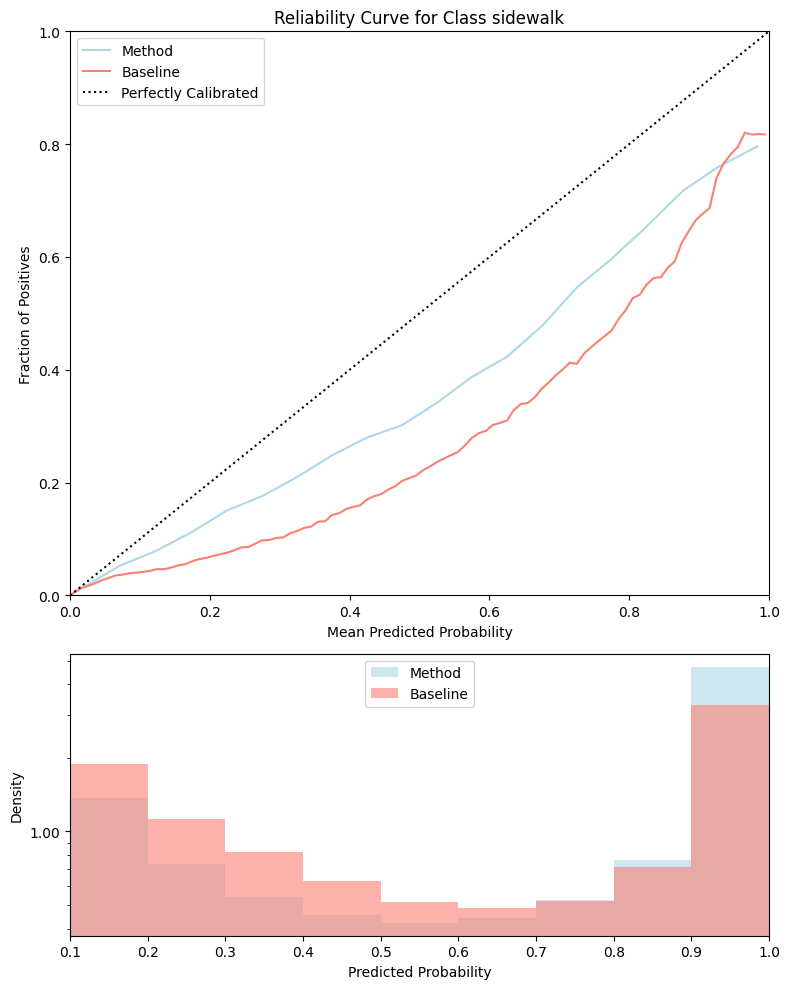

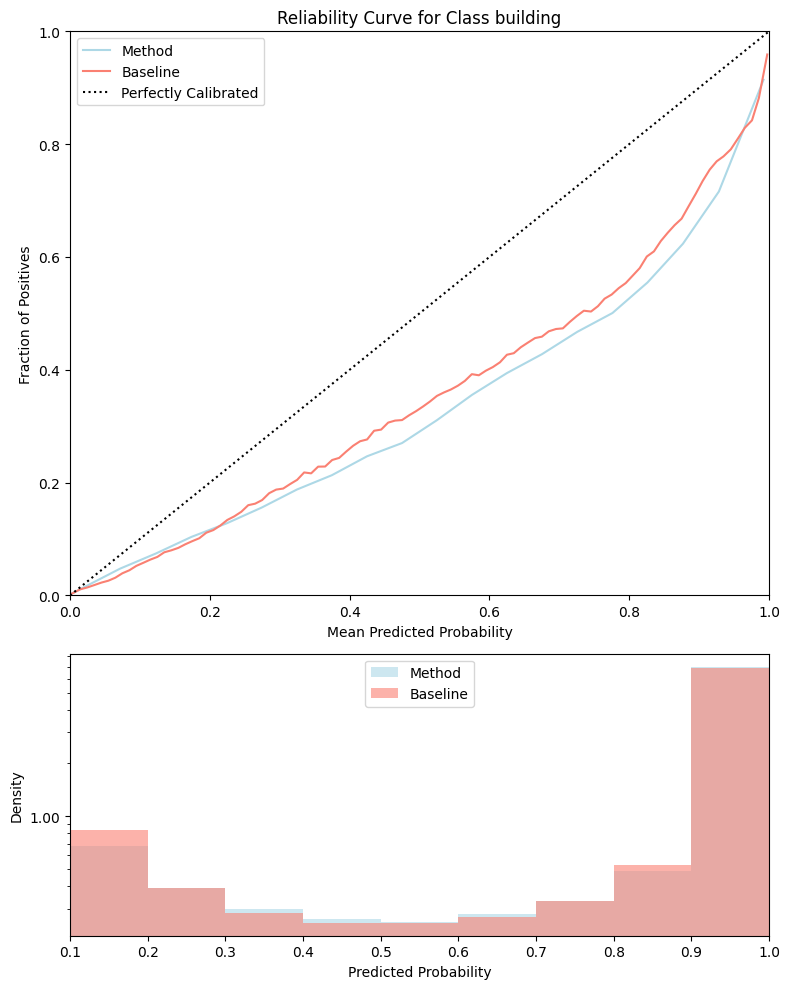

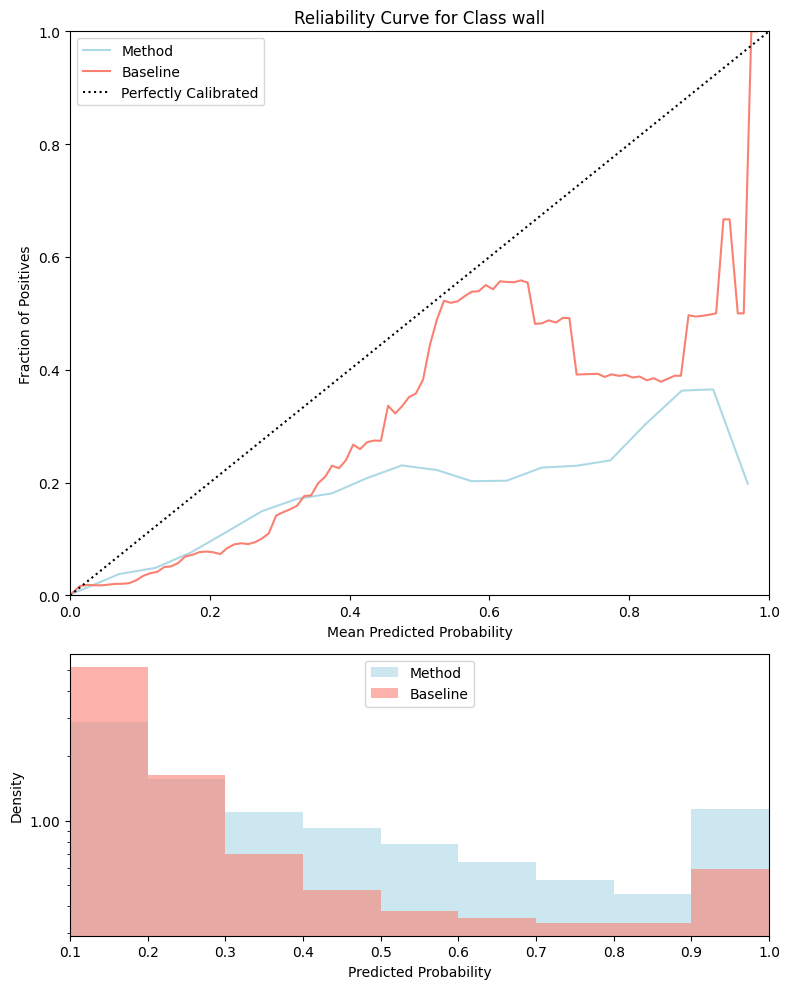

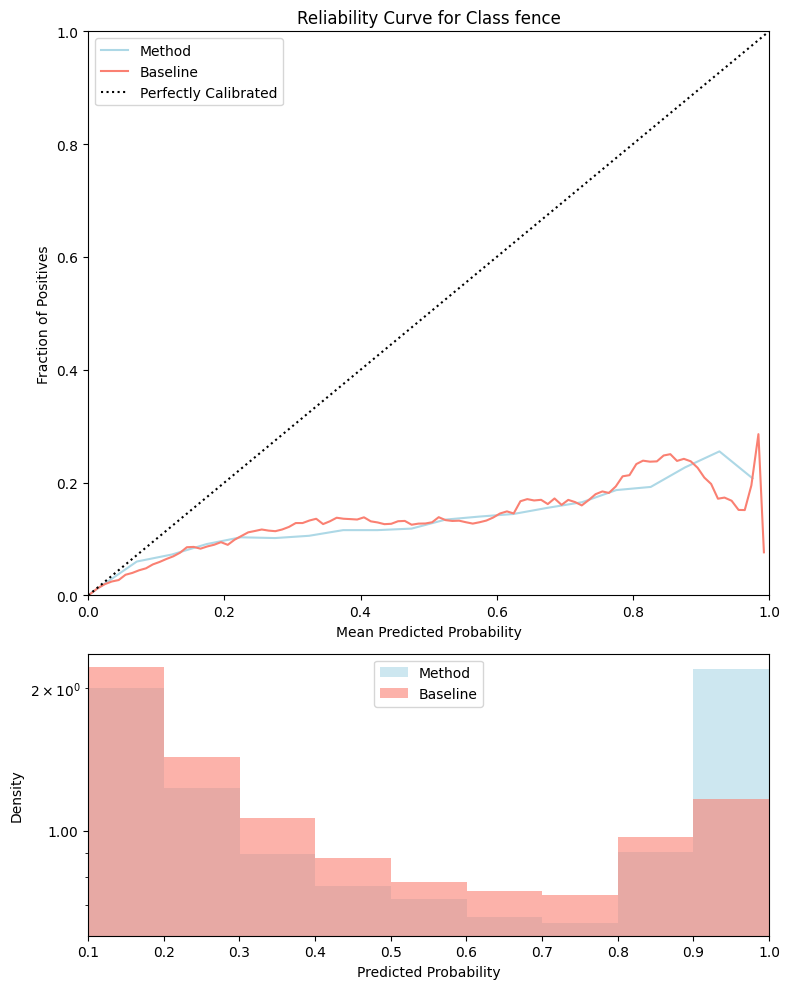

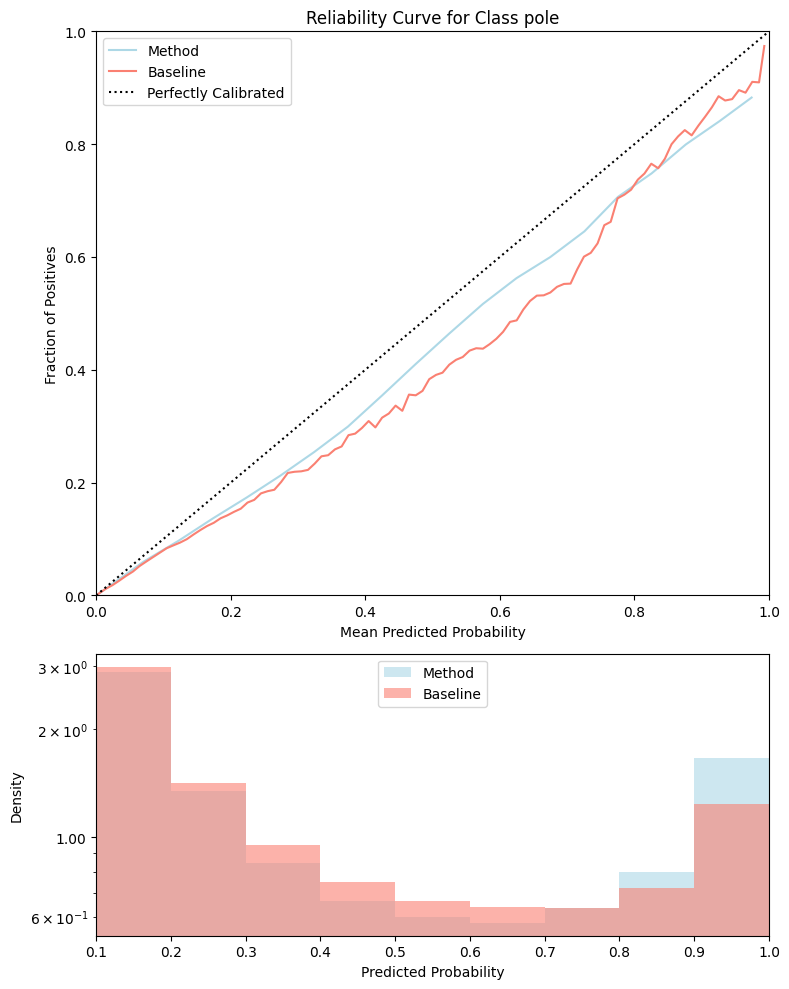

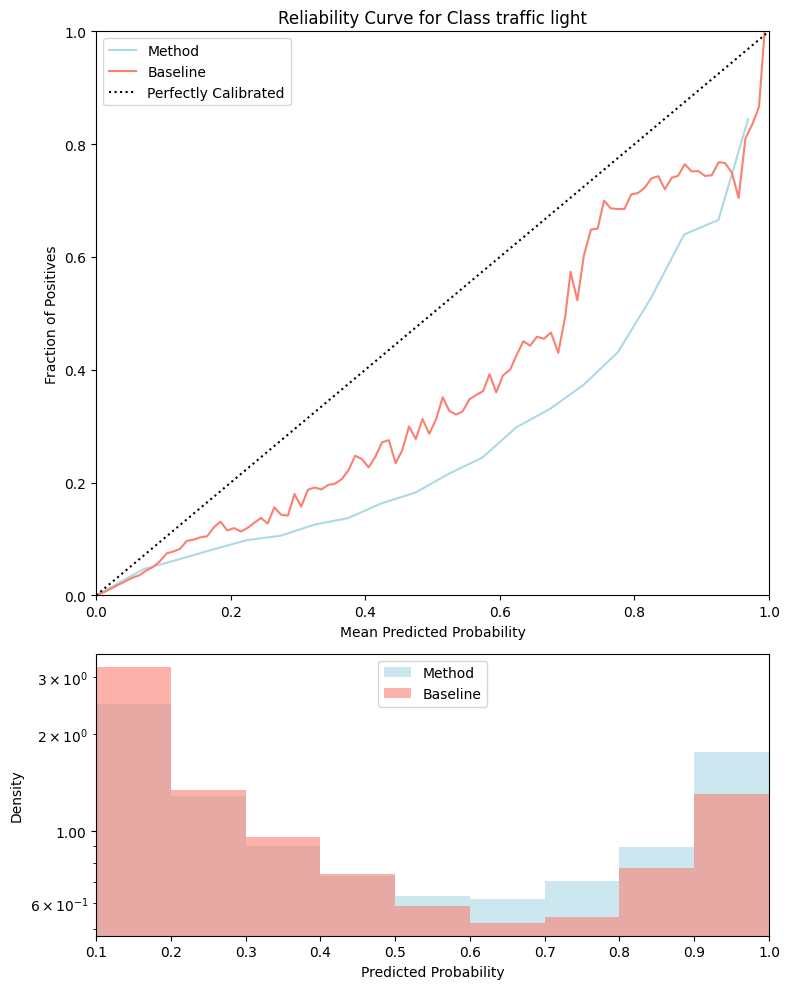

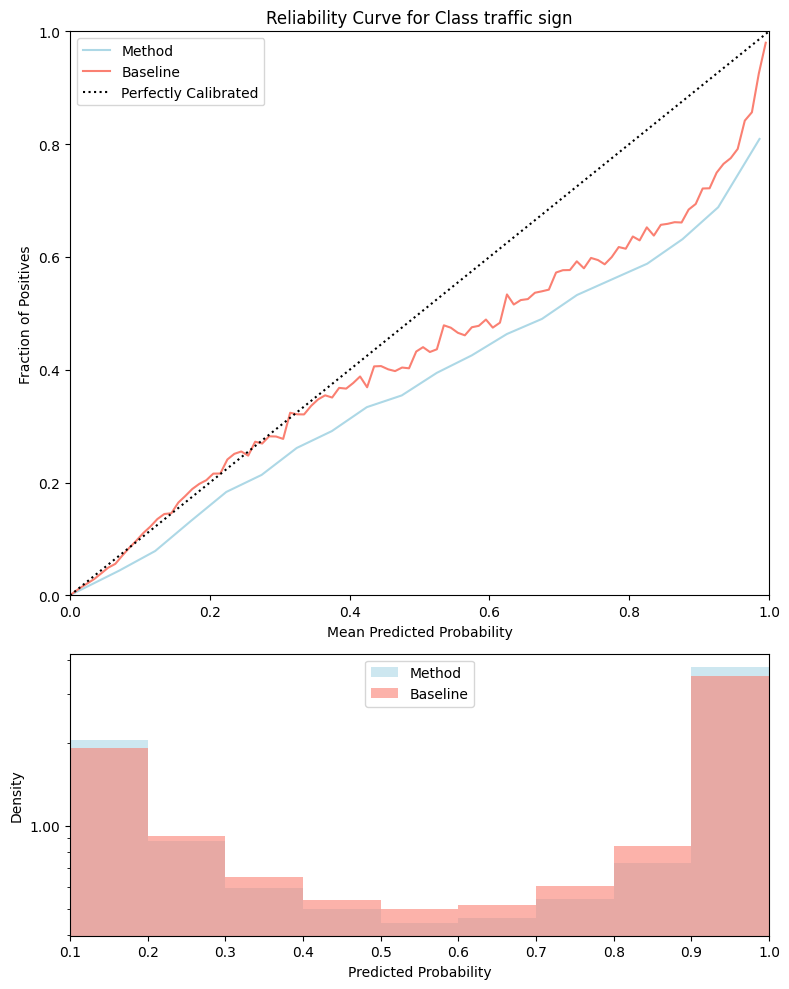

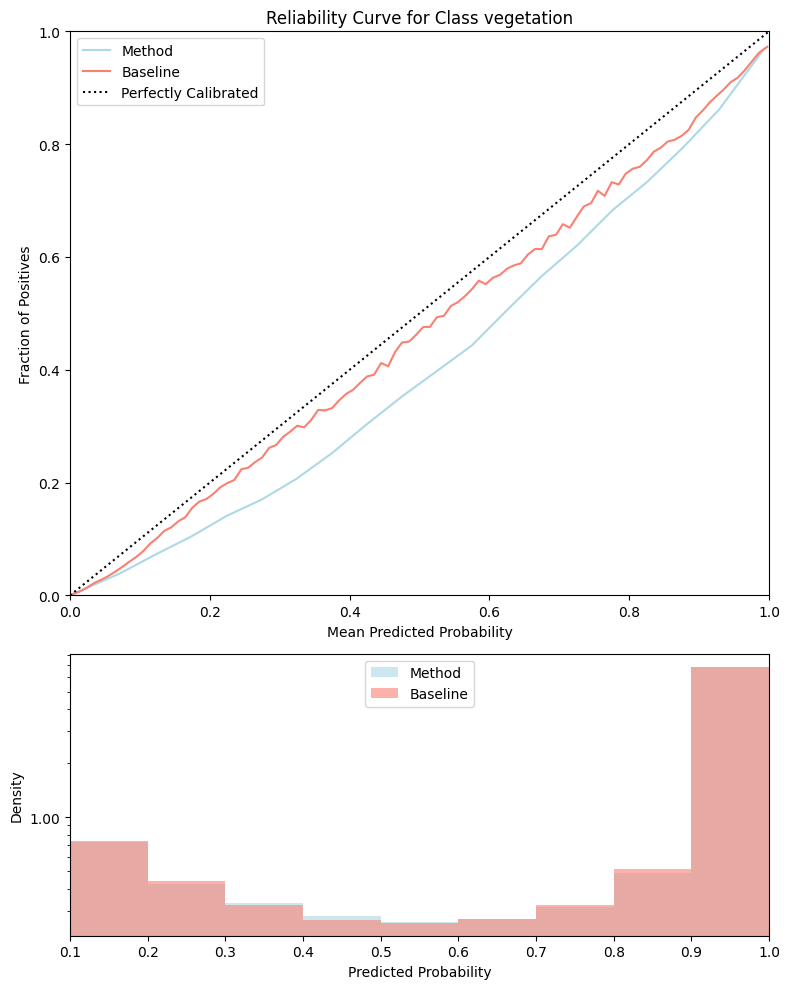

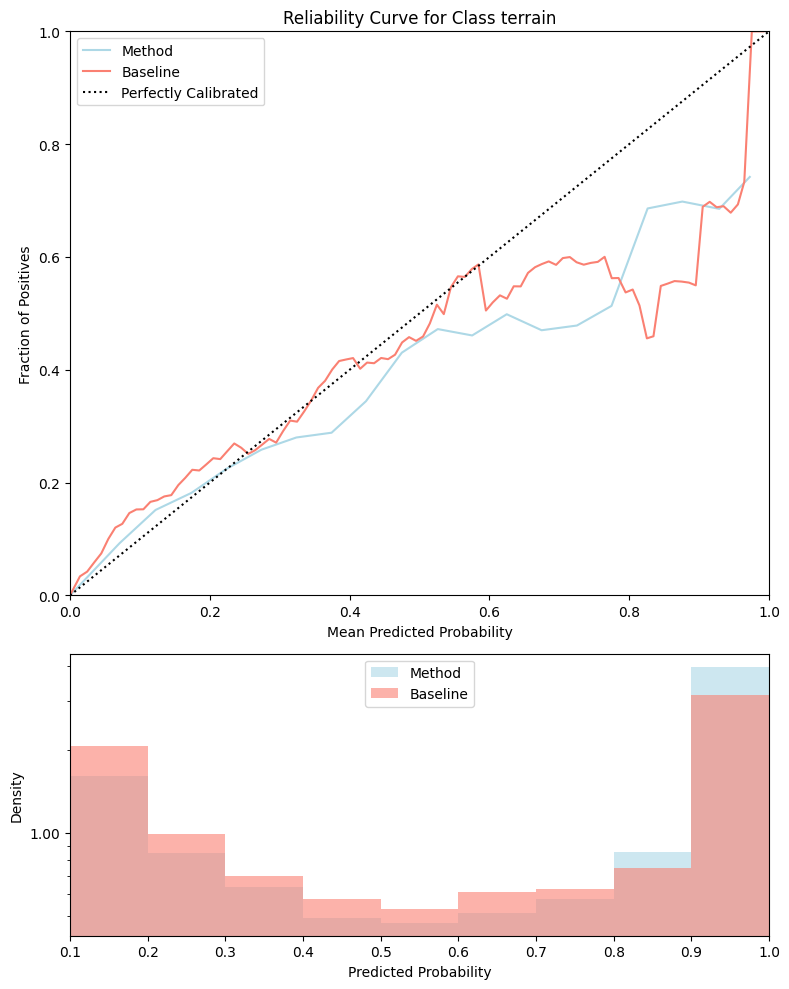

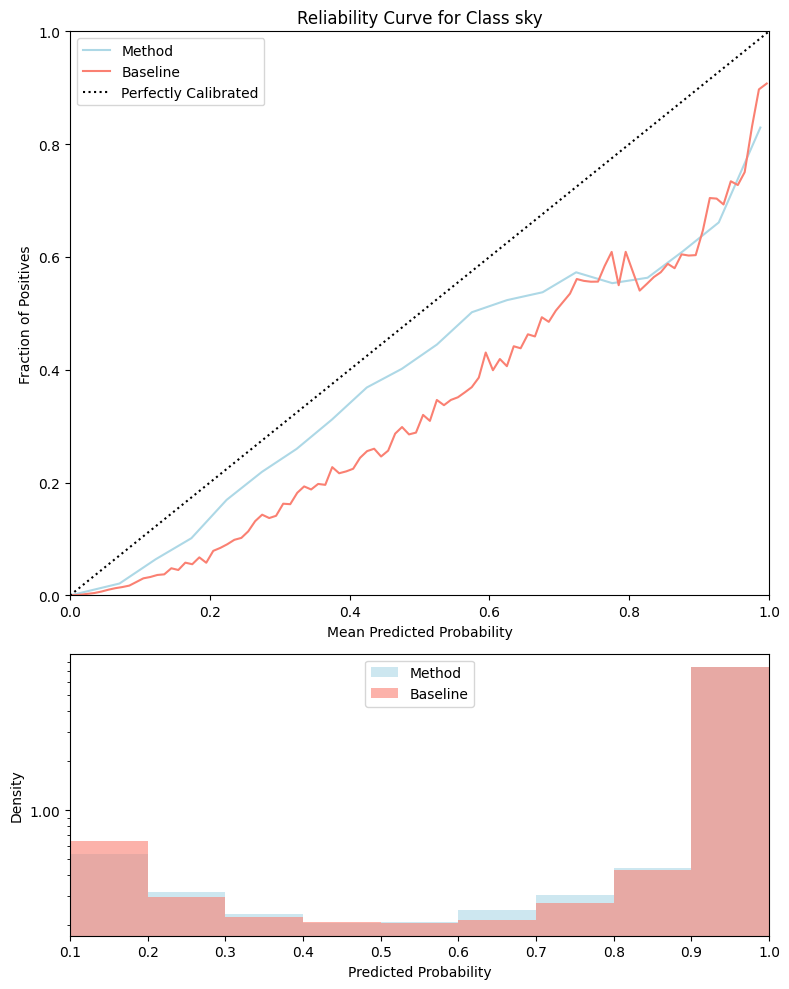

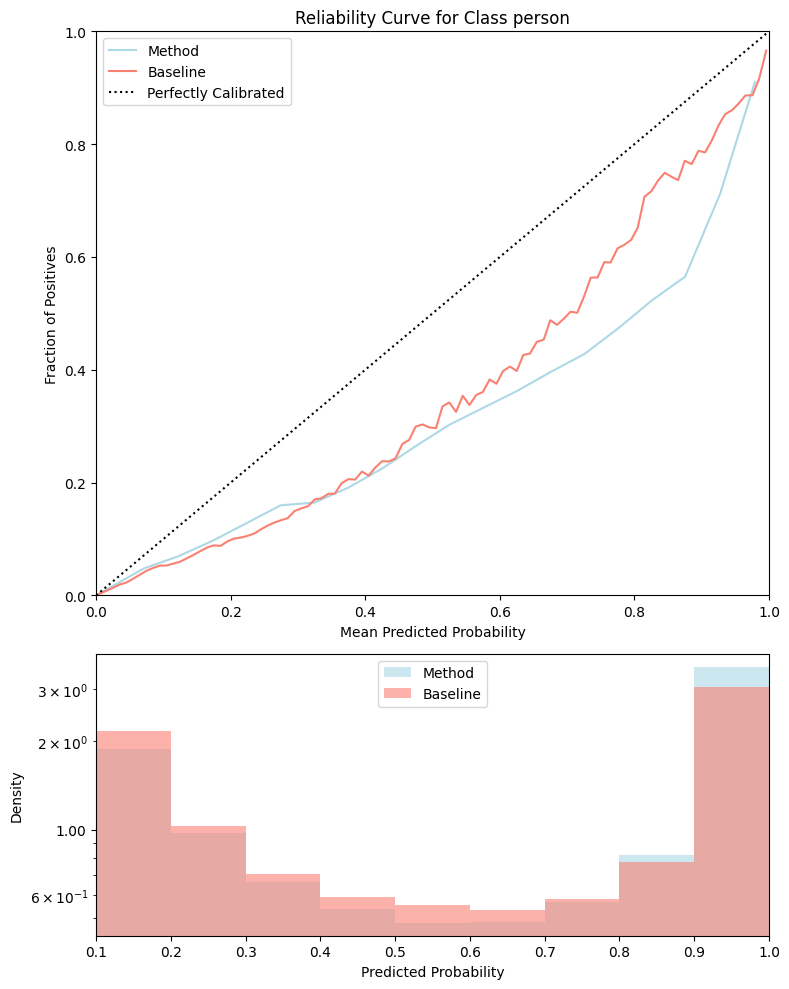

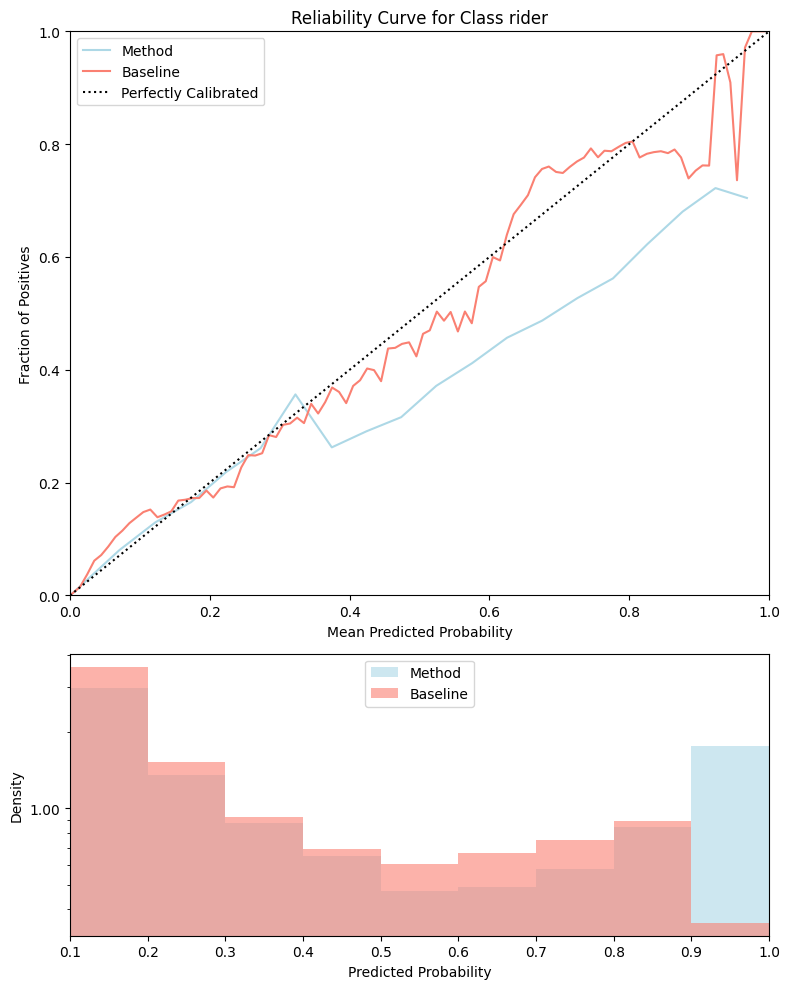

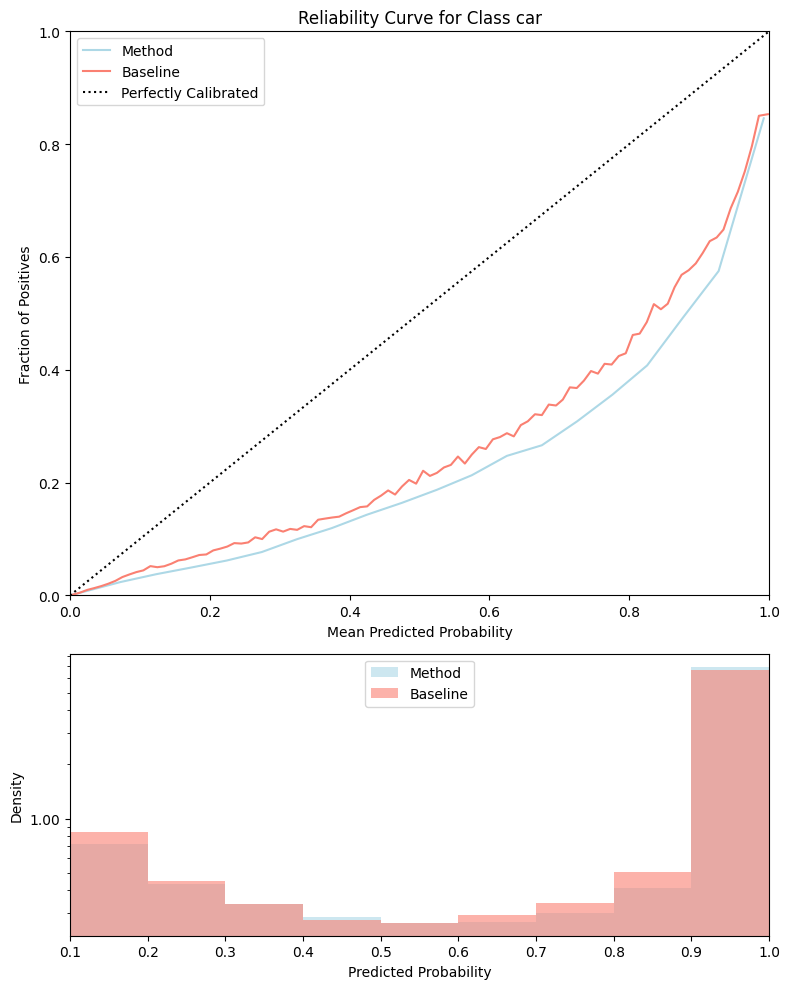

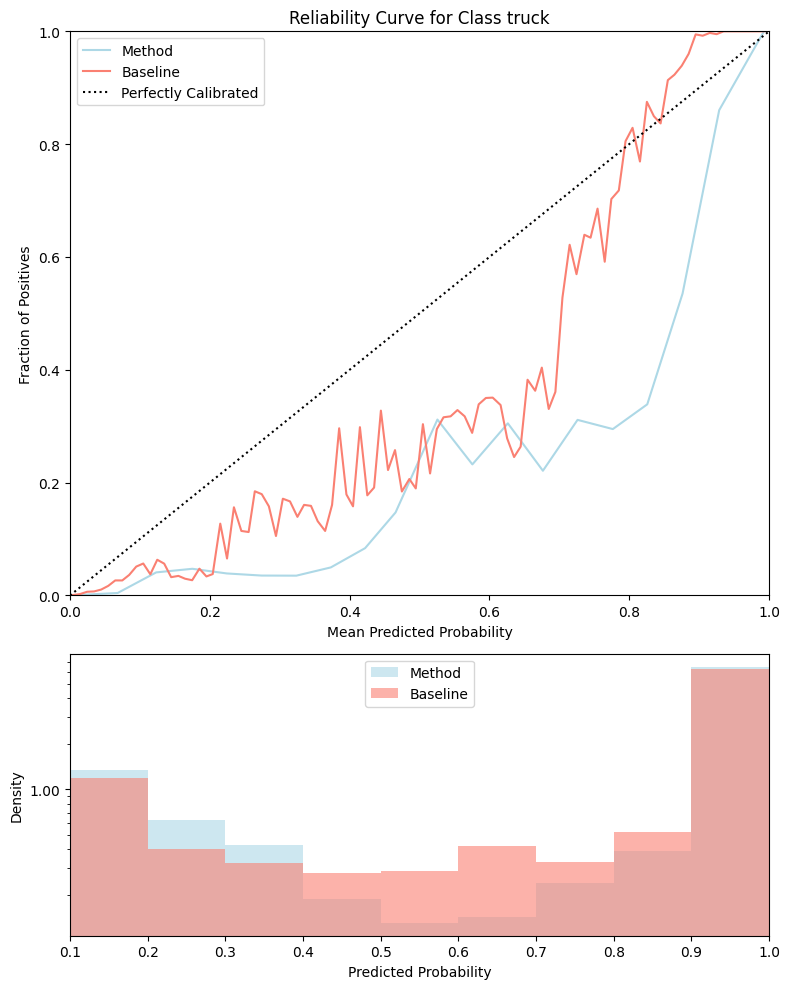

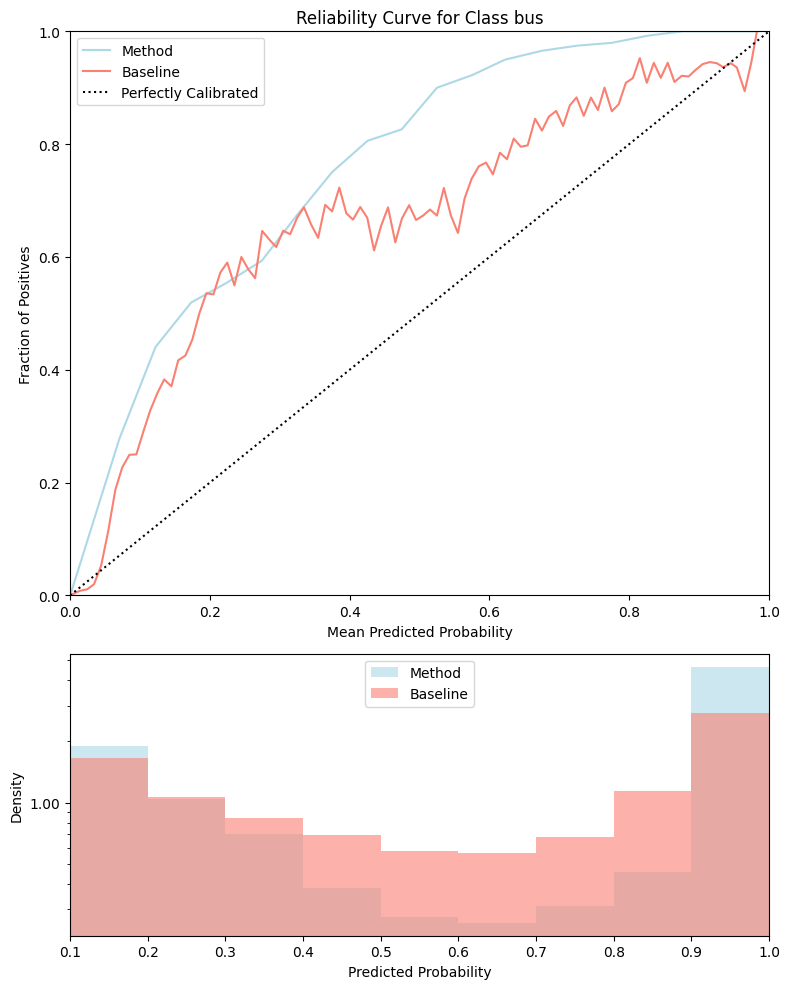

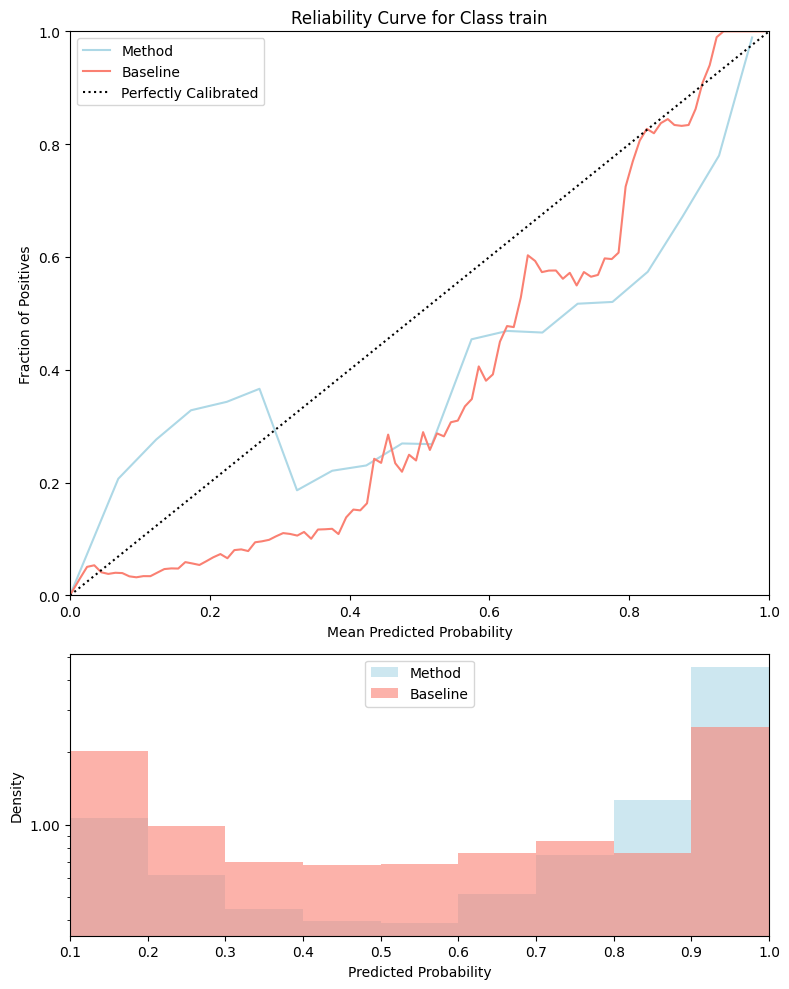

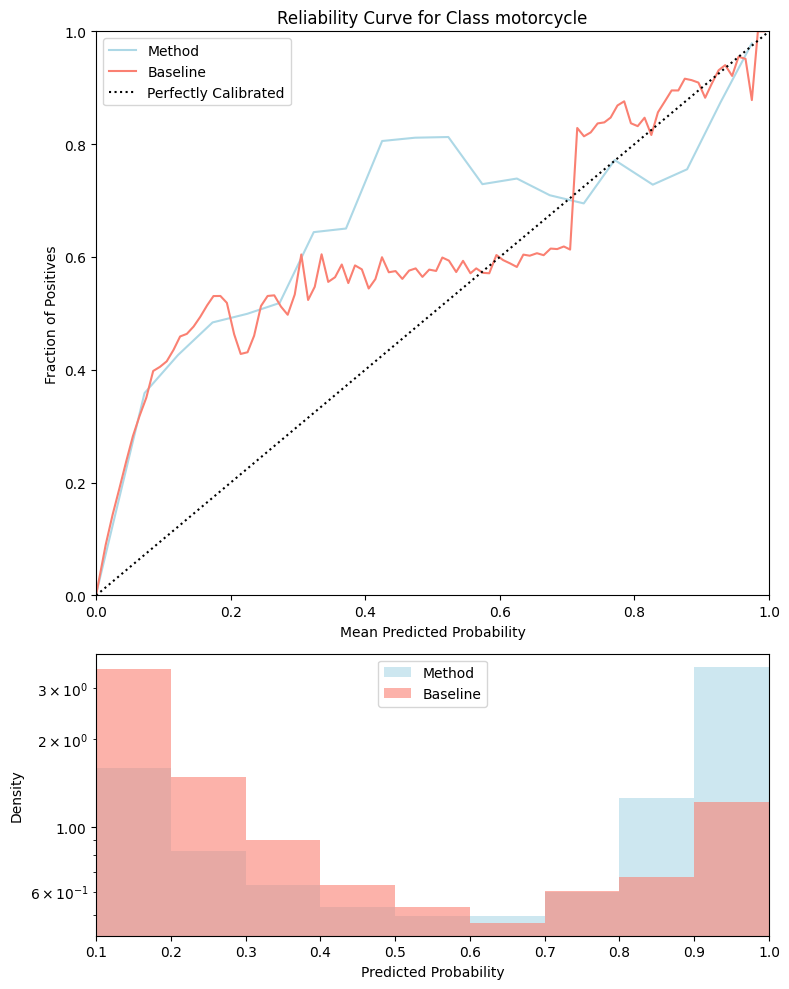

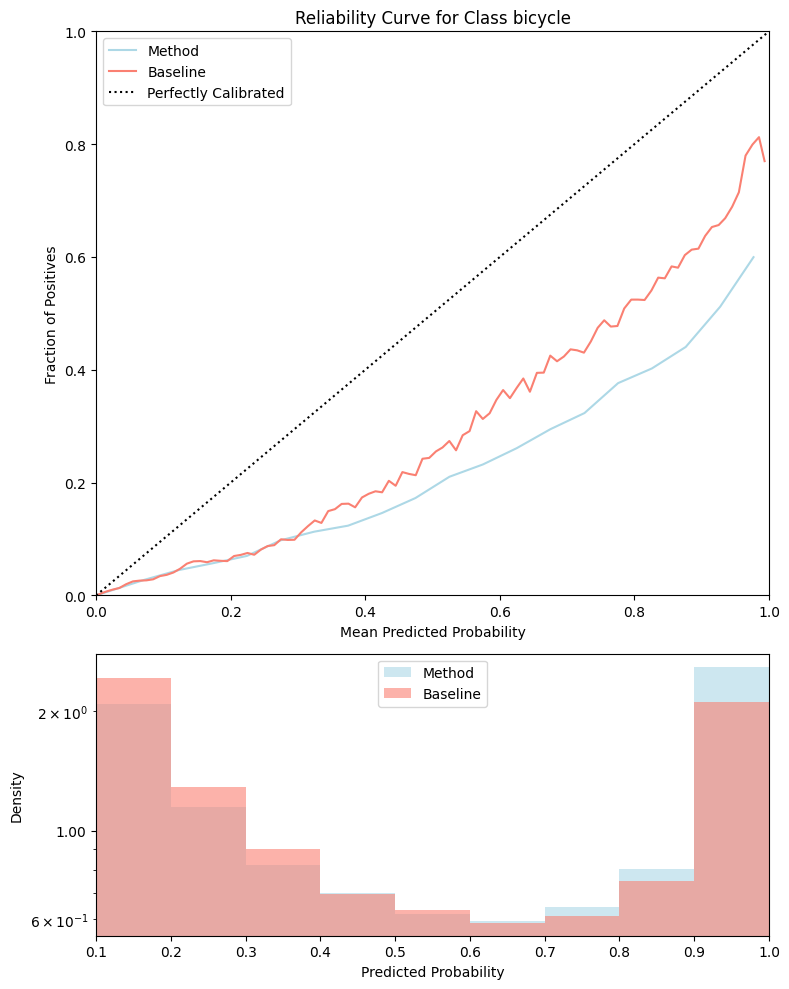

In [26]:
method_average_fraction_of_positives = {}
method_average_mean_predicted_value = {}
baseline_average_fraction_of_positives = {}
baseline_average_mean_predicted_value = {}

for positive_class in range(1, num_classes):
    # --- Average for Method ---
    if method_all_fraction_of_positives[positive_class]:
        max_len_method = max(len(arr) for arr in method_all_fraction_of_positives[positive_class])
        padded_fractions_method = [np.pad(arr, (0, max_len_method - len(arr)), constant_values=np.nan) for arr in method_all_fraction_of_positives[positive_class]]
        padded_means_method = [np.pad(arr, (0, max_len_method - len(arr)), constant_values=np.nan) for arr in method_all_mean_predicted_value[positive_class]]
        method_average_fraction_of_positives[positive_class] = np.nanmean(np.array(padded_fractions_method), axis=0)
        method_average_mean_predicted_value[positive_class] = np.nanmean(np.array(padded_means_method), axis=0)
    else:
        method_average_fraction_of_positives[positive_class] = np.array([])
        method_average_mean_predicted_value[positive_class] = np.array([])

    # --- Average for Baseline ---
    if baseline_all_fraction_of_positives[positive_class]:
        max_len_baseline = max(len(arr) for arr in baseline_all_fraction_of_positives[positive_class])
        padded_fractions_baseline = [np.pad(arr, (0, max_len_baseline - len(arr)), constant_values=np.nan) for arr in baseline_all_fraction_of_positives[positive_class]]
        padded_means_baseline = [np.pad(arr, (0, max_len_baseline - len(arr)), constant_values=np.nan) for arr in baseline_all_mean_predicted_value[positive_class]]
        baseline_average_fraction_of_positives[positive_class] = np.nanmean(np.array(padded_fractions_baseline), axis=0)
        baseline_average_mean_predicted_value[positive_class] = np.nanmean(np.array(padded_means_baseline), axis=0)
    else:
        baseline_average_fraction_of_positives[positive_class] = np.array([])
        baseline_average_mean_predicted_value[positive_class] = np.array([])

    fig, axes = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]})

    # Top subplot: Calibration Curve
    ax1 = axes[0]
    if method_average_mean_predicted_value[positive_class].size > 0:
        ax1.plot(method_average_mean_predicted_value[positive_class], method_average_fraction_of_positives[positive_class], label=f"Method", color='lightblue')
    if baseline_average_mean_predicted_value[positive_class].size > 0:
        ax1.plot(baseline_average_mean_predicted_value[positive_class], baseline_average_fraction_of_positives[positive_class], label=f"Baseline", color='salmon')
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
    ax1.set_xlabel("Mean Predicted Probability")
    ax1.set_ylabel("Fraction of Positives")
    ax1.set_title(f"Reliability Curve for Class {classes[positive_class]}")
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    ax2 = axes[1]
    hist_color_method = 'lightblue'
    hist_color_baseline = 'salmon'
    alpha = 0.6

    n_method, bins_method, _ = ax2.hist(
        method_all_predicted_probabilities[positive_class][method_all_predicted_probabilities[positive_class] > 0.1],
        bins=10,
        range=(0, 1),
        histtype='stepfilled',
        alpha=alpha,
        color=hist_color_method,
        label='Method',
        density=True,  # Normalize to density
    )

    n_baseline, bins_baseline, _ = ax2.hist(
        baseline_all_predicted_probabilities[positive_class][baseline_all_predicted_probabilities[positive_class] > 0.1],
        bins=10,
        range=(0, 1),
        histtype='stepfilled',
        alpha=alpha,
        color=hist_color_baseline,
        label='Baseline',
        density=True,  # Normalize to density
    )

    ax2.set_xlabel("Predicted Probability")
    ax2.set_ylabel("Density")
    ax2.legend(loc='upper center')
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax2.ticklabel_format(axis='y', style='plain')
    
    ax2.set_xlim(0.1, 1)

    fig.tight_layout()
    plt.savefig(f'{image_output_directory}/calibration_{classes[positive_class]}.png', dpi=300, bbox_inches='tight')

    